# Hyperparameter tuning using the Fashion MNIST dataset
We will train and evaluate an MLP on the Fashion MNIST dataset. It consists of 70.000 grayscale images of 28x28 pixels each, and there are 10 classes.

Hyperparameters:
1. Optimizer: Momentum optimization
2. Activation function: SELU
3. Weight initialization: LeCun

## Setup

In [3]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
# Split the full training set into a validation set and a (smaller) training set.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## Standardize the data
Because we want to use the SELU activation function and LeCun weight initializer, we should standardize all the input features to a mean of 0 and a standard deviation of 1. Since each pixel is an input feature, there are 28x28=784 input features, and we need to compute the mean and standard deviation for each of them.

In [6]:
X_train.shape

(55000, 28, 28)

In [4]:
# Compute the mean for each pixel over the whole training set.
pixel_means = X_train.mean(axis=0)
pixel_means.shape

(28, 28)

In [5]:
# Compute the standard deviation for each pixel over the whole training set.
pixel_stds = X_train.std(axis=0)
pixel_stds.shape

(28, 28)

In [6]:
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
X_train_standardized = (X_train - pixel_means) / pixel_stds

X_valid_standardized = (X_valid - X_valid.mean(axis=0)) / X_valid.std(axis=0)
X_test_standardized = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

In [7]:
# Validate that the mean is close to 0 for each pixel.
X_train_standardized.mean(axis=0)

array([[ 2.02095556e-15,  1.62754053e-15,  4.46262219e-16,
         1.14067644e-15, -7.41440495e-16, -2.63235242e-15,
        -1.34868732e-15, -2.60230625e-15,  1.66292233e-16,
         6.41022589e-16,  1.30749956e-16, -1.75860942e-15,
         1.77240041e-16, -4.50241864e-16,  5.90933363e-16,
        -7.87533675e-16,  2.07429427e-15, -2.87339849e-16,
        -4.16042958e-16, -6.74107235e-17,  2.68472416e-15,
        -2.27123371e-16, -5.26867943e-16, -1.31060062e-15,
        -2.53719217e-15, -4.31397342e-17,  1.73844777e-16,
         1.29615371e-15],
       [ 3.54259040e-15, -7.59241659e-16,  4.87038213e-15,
        -8.00087774e-16, -1.62997292e-15,  7.67104562e-16,
         1.68777820e-15, -2.78451504e-15,  6.71137893e-16,
        -2.99043013e-15, -2.08019057e-15,  7.63978779e-16,
         7.48899932e-16,  1.82329707e-15, -5.25664361e-16,
        -9.88134826e-16,  9.29450456e-16, -5.45922903e-16,
        -1.89077037e-16,  4.06024709e-16, -7.56264748e-16,
         5.24574323e-16, -5.09

In [8]:
# Validate that the standard deviation is close to 1 for each pixel.
X_train_standardized.std(axis=0)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1

## Create a model using the Sequential API

In [10]:
model = keras.models.Sequential()
# Input layer:
model.add(keras.layers.Flatten(input_shape=[28, 28]))

# Hidden layers:
for layer in range(3):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
    
# Output layer.
model.add(keras.layers.Dense(10, activation="softmax"))

## Compile the model
You must at least specify the loss function and the optimizer to use. You can also specify a list of additional metrics to use during training and evaluation.

In [11]:
# The optimixer is Stochastic Gradient Descent with momentum optimization. The momentum is set to 0.9.
# This value usually works well in practice. We use the default learning rate (0.01).
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

## Train the model

In [12]:
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(X_train_standardized, y_train, epochs=40,
                    validation_data=(X_valid_standardized, y_valid),
                    callbacks=[early_stopping])

Epoch 1/40
1719/1719 [==============================] - 1s 816us/step - loss: 0.4796 - accuracy: 0.8313 - val_loss: 0.3732 - val_accuracy: 0.8642
Epoch 2/40
1719/1719 [==============================] - 1s 794us/step - loss: 0.3630 - accuracy: 0.8689 - val_loss: 0.3845 - val_accuracy: 0.8634
Epoch 3/40
1719/1719 [==============================] - 1s 792us/step - loss: 0.3270 - accuracy: 0.8789 - val_loss: 0.3375 - val_accuracy: 0.8790
Epoch 4/40
1719/1719 [==============================] - 1s 793us/step - loss: 0.3046 - accuracy: 0.8870 - val_loss: 0.3445 - val_accuracy: 0.8852
Epoch 5/40
1719/1719 [==============================] - 1s 788us/step - loss: 0.2833 - accuracy: 0.8948 - val_loss: 0.3389 - val_accuracy: 0.8812
Epoch 6/40
1719/1719 [==============================] - 1s 797us/step - loss: 0.2696 - accuracy: 0.9005 - val_loss: 0.3592 - val_accuracy: 0.8796
Epoch 7/40
1719/1719 [==============================] - 1s 802us/step - loss: 0.2571 - accuracy: 0.9051 - val_loss: 0.3544 -

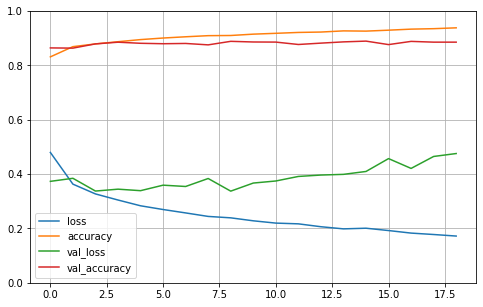

In [13]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model.

In [14]:
model.evaluate(X_test_standardized, y_test)

313/313 [==============================] - 0s 543us/step - loss: 0.3844 - accuracy: 0.8800


[0.3844279646873474, 0.8799999952316284]